# Time-series prediction with Keras `SimpleRNN` class
### Dr. Tirthajyoti Sarkar, Fremont, CA 94536 ([LinkedIn](https://www.linkedin.com/in/tirthajyoti-sarkar-2127aa7/), [Github](https://tirthajyoti.github.io))

For more tutorial-style notebooks on deep learning, **[here is my Github repo](https://github.com/tirthajyoti/Deep-learning-with-Python)**.

For more tutorial-style notebooks on general machine learning, **[here is my Github repo](https://github.com/tirthajyoti/Machine-Learning-with-Python)**.

---
### What is this Notebook about?
In this notebook, we show a building simple recurrent neural network (RNN) using Keras.

We will generate some synthetic time-series data by multiplying two periodic/ sinusoidal signals and adding some stochasticity (Gaussian noise). Then, we will take a small fraction of the data and train a simple RNN model with it and try to predict the rest of the data and see how the predictions match up with the ground truth.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv

from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Input
from keras.optimizers import RMSprop
from keras.callbacks import Callback
from sklearn.preprocessing import MinMaxScaler

In [2]:
file = read_csv("AMAZON.csv", sep=';')
file=file.loc[::-1].reset_index(drop=True)
file

,Date,open,high,low,close,volume
0,1/2/2024 4:00,152.45,152.86,152.12,152.500,2047
1,1/2/2024 4:01,152.65,152.68,152.44,152.600,203
2,1/2/2024 4:02,152.65,152.66,152.64,152.650,1187
3,1/2/2024 4:03,152.52,152.52,152.50,152.500,100
4,1/2/2024 4:04,152.52,152.52,152.36,152.360,1740
...,...,...,...,...,...,...
116810,6/28/2024 19:55,193.33,193.35,193.25,193.270,895
116811,6/28/2024 19:56,193.30,193.34,193.25,193.315,217
116812,6/28/2024 19:57,193.32,193.35,193.24,193.350,429
116813,6/28/2024 19:58,193.32,193.35,193.28,193.300,765


In [3]:
N=15     #Minutos agrupados
DateFilter='1/12' #Filtro de fecha

df = file[file['Date'].str.startswith(DateFilter)] #Seleccionamos el rango de fechas
df=pd.DataFrame(df)
df=df.drop(columns=["Date"])
dfgroup=pd.DataFrame(df['open'].groupby(df.index//N).first())
dfgroup=dfgroup.join(pd.DataFrame(df['close'].groupby(df.index//N).last()))
dfgroup=dfgroup.join(pd.DataFrame(df['low'].groupby(df.index//N).min()))
dfgroup=dfgroup.join(pd.DataFrame(df['high'].groupby(df.index//N).max()))
dfgroup=dfgroup.join(pd.DataFrame(df['volume'].groupby(df.index//N).sum()))
dfgroup = dfgroup.reset_index(drop=True)
dfgroup

,open,close,low,high,volume
0,155.00,154.970,154.00,155.08,1601
1,154.96,154.960,154.84,155.12,5044
2,154.94,154.910,154.65,155.04,5728
3,154.89,154.430,154.38,154.90,3737
4,154.41,154.310,154.31,154.53,3574
...,...,...,...,...,...
59,154.43,154.450,154.31,154.45,2887
60,154.42,154.385,154.32,154.45,2373
61,154.40,154.410,154.36,154.41,2516
62,154.41,154.340,154.33,154.45,4922


In [4]:
dfgroup['open']=pd.DataFrame(1-dfgroup['close'].shift(periods=1)/dfgroup['open'])
dfgroup['high']=pd.DataFrame(1-dfgroup['close'].shift(periods=1)/dfgroup['high'])
dfgroup['low']=pd.DataFrame(1-dfgroup['close'].shift(periods=1)/dfgroup['low'])
dfgroup['close']=pd.DataFrame(1-dfgroup['close'].shift(periods=1)/dfgroup['close'])
dfgroup=dfgroup.drop(0).reset_index(drop=True)
dfgroup

,open,close,low,high,volume
0,-0.000065,-0.000065,-0.000840,0.000967,5044
1,-0.000129,-0.000323,-0.002005,0.000516,5728
2,-0.000129,-0.003108,-0.003433,-0.000065,3737
3,-0.000130,-0.000778,-0.000778,0.000647,3574
4,0.000842,0.002069,0.000130,0.002134,3906
...,...,...,...,...,...
58,0.000356,0.000486,-0.000421,0.000486,2887
59,-0.000194,-0.000421,-0.000842,0.000000,2373
60,0.000097,0.000162,-0.000162,0.000162,2516
61,0.000000,-0.000454,-0.000518,0.000259,4922


In [7]:
LIMITE=0.001

decision=dfgroup['close'].iloc[:]
decision = np.where(abs(decision)<LIMITE,None,np.sign(decision).astype('int'))
decision = pd.DataFrame(data={'order':decision}).drop(0).reset_index(drop=True)
normData = dfgroup.join(decision)
normData

,open,close,low,high,volume,order
0,-0.000065,-0.000065,-0.000840,0.000967,5044,None
1,-0.000129,-0.000323,-0.002005,0.000516,5728,-1
2,-0.000129,-0.003108,-0.003433,-0.000065,3737,None
3,-0.000130,-0.000778,-0.000778,0.000647,3574,1
4,0.000842,0.002069,0.000130,0.002134,3906,None
...,...,...,...,...,...,...
58,0.000356,0.000486,-0.000421,0.000486,2887,None
59,-0.000194,-0.000421,-0.000842,0.000000,2373,None
60,0.000097,0.000162,-0.000162,0.000162,2516,None
61,0.000000,-0.000454,-0.000518,0.000259,4922,-1


In [162]:
np.count_nonzero(normData['order'])

54

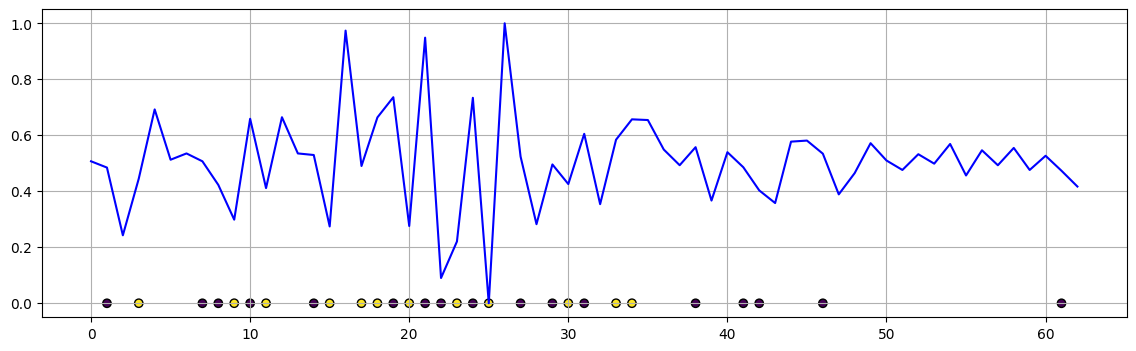

In [25]:
plt.figure(figsize=(14,4))
#plt.plot(df.iloc[750:800],c='blue')
plt.plot(normData['close'],c='blue')

plt.scatter(normData.index, normData['order']/10000,ec='k',c=normData['order'])
plt.grid(True)
plt.show()

In [9]:
#Normalise data into (0,1) range
scaler = MinMaxScaler(feature_range=(0, 1))
normData[['open','close','low','high','volume']] = scaler.fit_transform(normData[['open','close','low','high','volume']])
normData

,open,close,low,high,volume,order
0,0.461877,0.507039,0.889428,0.032985,0.000217,None
1,0.423549,0.484615,0.756520,0.018564,0.000263,-1
2,0.423525,0.242745,0.593536,0.000000,0.000128,None
3,0.423286,0.445116,0.896493,0.022757,0.000117,1
4,1.000000,0.692341,1.000000,0.070301,0.000139,None
...,...,...,...,...,...,...
58,0.711664,0.554808,0.937157,0.017592,0.000070,None
59,0.384840,0.476083,0.889105,0.002064,0.000035,None
60,0.557879,0.526701,0.966737,0.007241,0.000045,None
61,0.500194,0.473259,0.926074,0.010346,0.000208,-1


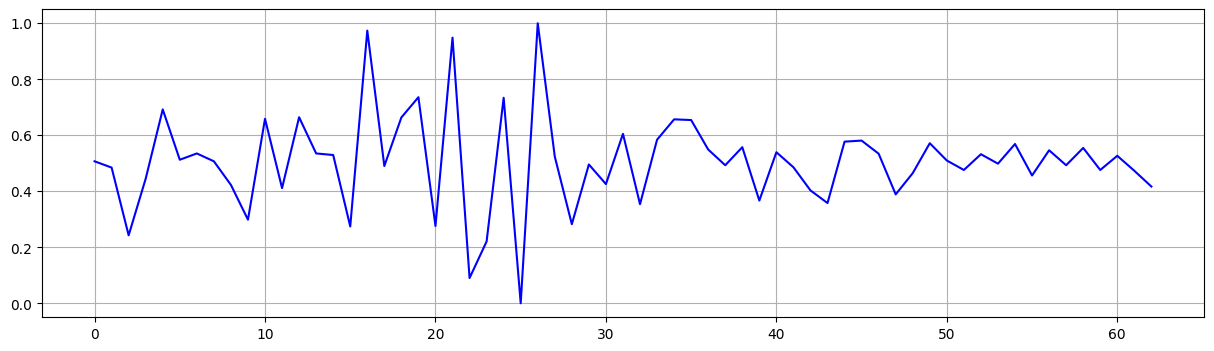

In [10]:
plt.figure(figsize=(15,4))
plt.plot(normData['close'],c='blue')
plt.grid(True)
plt.show()

### Split the values in train and test

So, we took only 25% of the data as training samples and set aside the rest of the data for testing.

Looking at the time-series plot, we think **it is not easy for a standard model to come up with correct trend predictions.**

In [65]:
S=0.7

split = int(len(normData) * S)
#values = normData.values
#print(values)
train = normData[:split].drop(['order'],axis=1)
test = normData[split:].drop(['order'],axis=1)
print("Train data length:", train.shape)
print("Test data length:", test.shape)

Train data length: (44, 5)
Test data length: (19, 5)


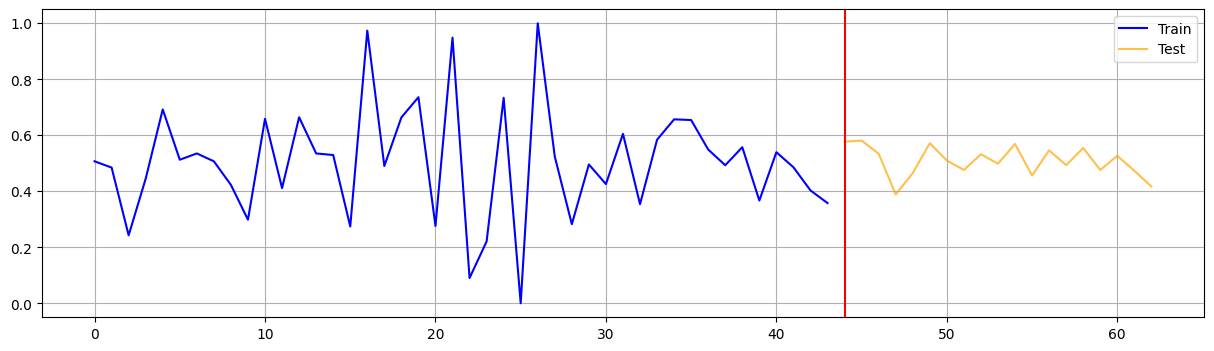

In [66]:
index = normData.index.values

plt.figure(figsize=(15,4))
plt.plot(index[0:split],train['close'],c='blue')
plt.plot(index[split:],test['close'],c='orange',alpha=0.7)
plt.legend(['Train','Test'])
plt.axvline(normData.index[split], c="r")
plt.grid(True)
plt.show()

In [67]:
step = 10
aux = train.tail(step)
train= pd.concat([train, test.head(step)]).reset_index(drop=True)
test = pd.concat([aux,test]).reset_index(drop=True)
print("Train data length:", train.shape)
print("Test data length:", test.shape)

Train data length: (54, 5)
Test data length: (29, 5)


### Converting to a multi-dimensional array
Next, we'll convert test and train data into the matrix with step value as it has shown above example.

In [68]:
def convertToMatrix(data, step):
    X, Y =[], []
    for i in range(len(data)-step):
        d=i+step
        #print(i, d, data[i:d])
        X.append(data[i:d])
        Y.append(data[d,1])
    return np.array(X), np.array(Y)

trainX,trainY =convertToMatrix(train.to_numpy(),step)
testX,testY =convertToMatrix(test.to_numpy(),step)

print("Training data shape:", trainX.shape,', ',trainY.shape)
print("Test data shape:", testX.shape,', ',testY.shape)

Training data shape: (44, 10, 5) ,  (44,)
Test data shape: (19, 10, 5) ,  (19,)


In [70]:
#Este paso probablemente no es necesario. Comprobar

trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], trainX.shape[2]))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], testX.shape[2]))
print("Training data shape:", trainX.shape,', ',trainY.shape)
print("Test data shape:", testX.shape,', ',testY.shape)

Training data shape: (44, 10, 5) ,  (44,)
Test data shape: (19, 10, 5) ,  (19,)


### Keras model with `SimpleRNN` layer

- 256 neurons in the RNN layer
- 32 denurons in the densely connected layer
- a single neuron for the output layer
- ReLu activation
- learning rate: 0.001

In [71]:
UNITS = 150 #num_units: Number of units of a the simple RNN layer
DENSEUNITS = 32 #Number of neurons in the dense layer followed by the RNN layer
LR = 0.001 #Learning rate (uses RMSprop optimizer)
model = Sequential()
model.add(Input((step,trainX.shape[2])))
model.add(SimpleRNN(units=UNITS, activation="relu"))
model.add(Dense(DENSEUNITS, activation="relu"))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=RMSprop(LR),metrics=['mse'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)        │ (None, 150)            │        23,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         4,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,265 (110.41 KB)

 Trainable params: 28,265 (110.41 KB)

 Non-trainable params: 0 (0.00 B)

### Fit the model

In [72]:
class MyCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if ((epoch/10)+1) % 10 == 0 and epoch>0:
            print("Epoch number {} done".format(epoch+10))

batch_size=16
num_epochs = 1000

model.fit(trainX,trainY,
          epochs=num_epochs,
          batch_size=batch_size,
          callbacks=[MyCallback()],verbose=0)

Epoch number 100 done
Epoch number 200 done


### Plot loss

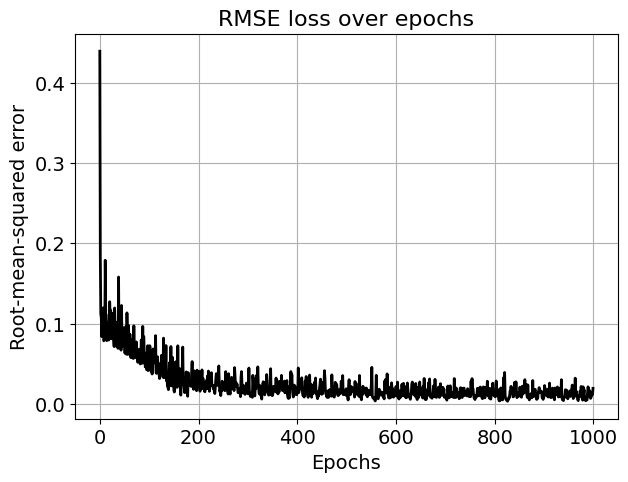

In [ ]:
plt.figure(figsize=(7,5))
plt.title("RMSE loss over epochs",fontsize=16)
plt.plot(np.sqrt(model.history.history['loss']),c='k',lw=2)
plt.grid(True)
plt.xlabel("Epochs",fontsize=14)
plt.ylabel("Root-mean-squared error",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### Predictions
Note that the model was fitted only with the `trainX` and `trainY` data.

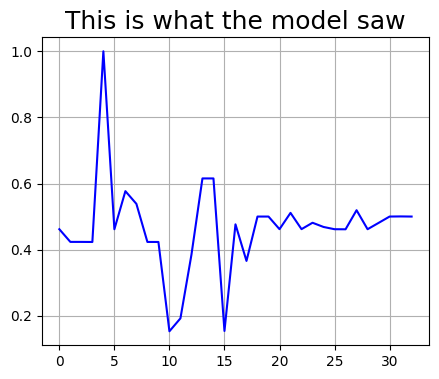

In [19]:
plt.figure(figsize=(5,4))
plt.title("This is what the model saw",fontsize=18)
plt.plot(trainX[:,0][:,0],c='blue')
plt.grid(True)
plt.show()

In [20]:
trainPredict = model.predict(trainX)
testPredict= model.predict(testX)
predicted=np.concatenate((trainPredict,testPredict),axis=0)
print(trainPredict.shape)
print(testPredict.shape)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
(33, 1)
(19, 1)


44    None
45    None
46      -1
47    None
48    None
49    None
50    None
51    None
52    None
53    None
54    None
55    None
56    None
57    None
58    None
59    None
60    None
61      -1
62     NaN
Name: order, dtype: object
RangeIndex(start=0, stop=19, step=1)


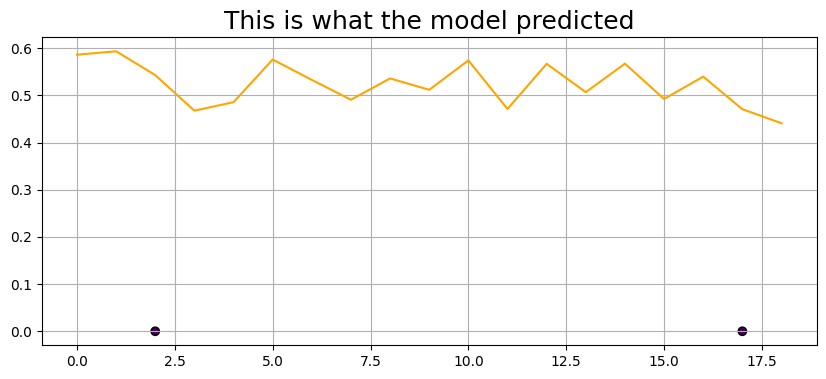

In [58]:
plt.figure(figsize=(10,4))
plt.title("This is what the model predicted",fontsize=18)
plt.plot(testPredict,c='orange')
print(normData['order'].iloc[split:])
print(normData['order'].iloc[split:].index-split)
plt.scatter(normData['order'].iloc[split:].index-split, normData.iloc[split:,-1]/10000,ec='k',c=normData['order'].iloc[split:])
plt.grid(True)
plt.show()

### Comparing it with the ground truth (test set)

(63,)
(52, 1)
(63,)


ValueError: x and y must have same first dimension, but have shapes (63,) and (52, 1)

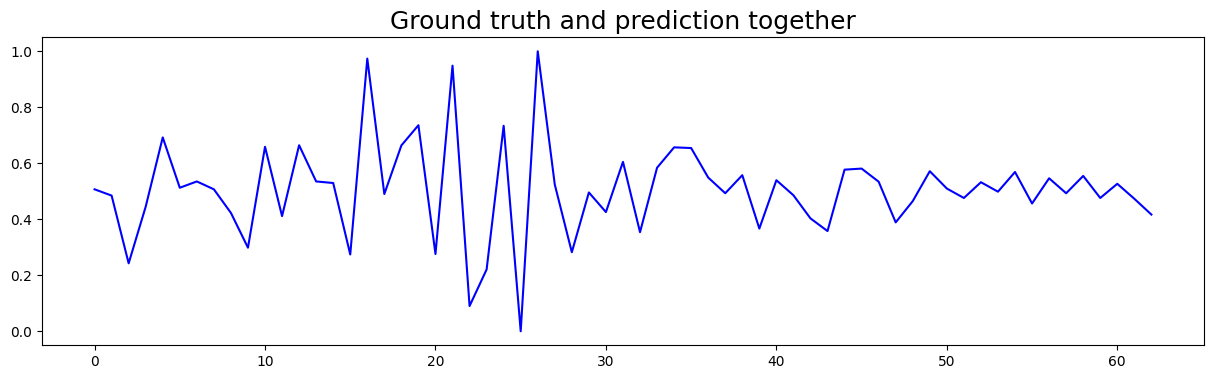

In [62]:
index = normData.index.values
print(index.shape)
print(predicted.shape)
print(normData['close'].shape)
plt.figure(figsize=(15,4))
plt.title("Ground truth and prediction together",fontsize=18)
plt.plot(index,normData['close'],c='blue')
plt.plot(index,predicted,c='orange',alpha=0.75)
plt.legend(['True data','Predicted'],fontsize=12)
plt.axvline(normData.index[split], c="r")
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [ ]:
print(testY)

[0.60953204 0.57812236 0.66253562 0.6067452  0.55249854 0.56756902
 0.60373799 0.56907981 0.63231532 0.57812236 0.58564796 0.61572038
 0.55103624 0.5931654  0.57210437 0.59015526 0.79968593 0.57213339
 0.61103869 0.62296561 0.59605285 0.54821928 0.59904523 0.54522063
 0.61398787 0.55419989 0.57812236 0.52123802 0.50916175 0.50003791
 0.59013229 0.58412656 0.71133878 0.56764234 0.47910339 0.57212045
 0.62309381 0.64697798 0.60531961 0.25703557 0.76304626 0.57773228
 0.69037627 0.57617654 0.56958917 0.51966504 0.53161049 0.71575502
 0.69750019 0.64580192 0.50287258 0.60497133 0.41197076 0.68267052
 0.44482138 0.5731193  0.58285532 0.36012271 0.7012751  0.55112318
 0.57644048 0.52565558 0.64090865 0.46401507 0.61872176 0.54953511
 0.63222558 0.59614988 0.57812236 0.57511758 0.58112695 0.60214682
 0.57211548 0.56310038 0.60214529 0.60513268 0.58412389 0.59012237
 0.59611551 0.58411931 0.63502474 0.59907709 0.58710125 0.5631528
 0.52116937 0.43380113 0.58413498 0.56308602 0.56609022 0.50280

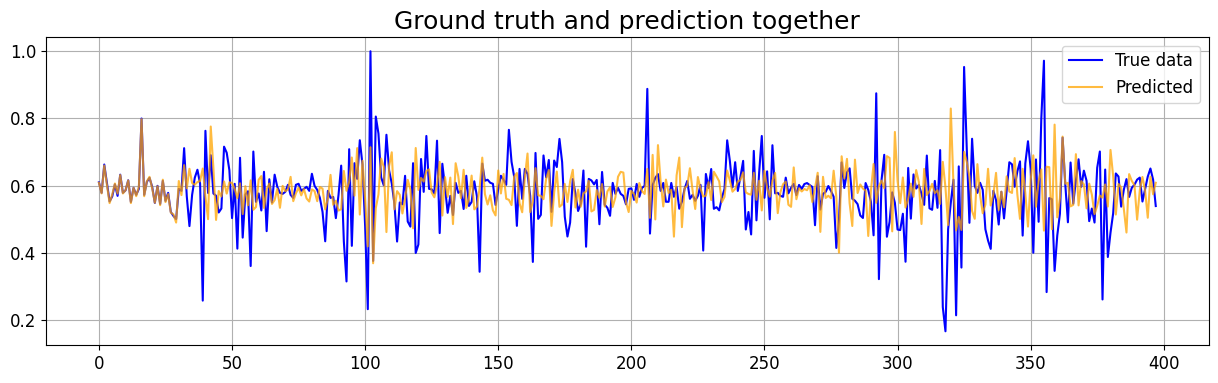

In [ ]:

plt.figure(figsize=(15,4))
plt.title("Ground truth and prediction together",fontsize=18)
plt.plot(testY,c='blue')
plt.plot(testPredict, c='orange',alpha=0.75)
plt.legend(['True data','Predicted'],fontsize=12)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()